In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def load_bekern_file(file_path: str) -> str:
    """Load bekern notation from a .semantic file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read().strip()
        return content

def semantic_to_kern(semantic_content: str) -> str:
    """
    Convert semantic file content to proper Kern format.
    Semantic files are already in Kern structure but use · instead of . 
    """
    kern_content = semantic_content.replace('**ekern_1.0', '**kern')
    
    return kern_content

def render_with_transposition(kern_str: str, transpose_semitones: int = 0) -> Optional[np.ndarray]:
    """Render kern notation with optional transposition using Verovio."""
    import verovio
    import cv2
    import cairosvg
    
    tk = verovio.toolkit()
    
    # Set options with transposition if specified
    options = {
        "pageWidth": 2100,
        "scale": 40,
        "adjustPageHeight": True,
        "footer": "none",
        "header": "none"
    }
    
    if transpose_semitones != 0:
        options["transpose"] = str(transpose_semitones)
    
    tk.setOptions(options)
    tk.loadData(kern_str)
    svg = tk.renderToSVG()
    
    # Convert SVG to PNG
    png_data = cairosvg.svg2png(bytestring=svg.encode('utf-8'), background_color='white')
    image_array = cv2.imdecode(np.frombuffer(png_data, np.uint8), -1)
    return cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)

def display_comparison(original_img, transposed_img, transpose_amount):
    """Display side-by-side comparison of original and transposed notation."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    if original_img is not None:
        axes[0].imshow(original_img)
        axes[0].set_title("Original Notation", fontsize=14)
    else:
        axes[0].text(0.5, 0.5, 'Rendering\nFailed', ha='center', va='center', 
                    transform=axes[0].transAxes)
        axes[0].set_title("Original Notation (Failed)", fontsize=14)
    
    if transposed_img is not None:
        axes[1].imshow(transposed_img)
        direction = "Up" if transpose_amount > 0 else "Down"
        axes[1].set_title(f"Transposed {abs(transpose_amount)} Semitones {direction}", fontsize=14)
    else:
        axes[1].text(0.5, 0.5, 'Rendering\nFailed', ha='center', va='center', 
                    transform=axes[1].transAxes)
        axes[1].set_title(f"Transposed {abs(transpose_amount)} Semitones (Failed)", fontsize=14)
    
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [10]:
# Configuration
SEMANTIC_FILE_PATH = "/home/stud/wiel/music_recognition/data/datasets/smt_datasets/camera-grandstaff/test/sample_000000/sample_000000.semantic"
CUSTOM_TRANSPOSE = 11

In [11]:
bekern_content = load_bekern_file(SEMANTIC_FILE_PATH)
kern_notation = semantic_to_kern(bekern_content)

✅ Loaded BeKern file: /home/stud/wiel/music_recognition/data/datasets/smt_datasets/camera-grandstaff/test/sample_000000/sample_000000.semantic


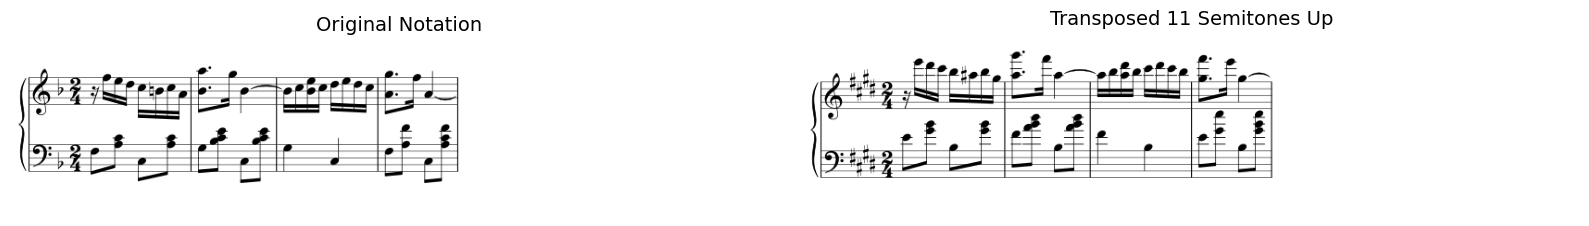

In [12]:
custom_original = render_with_transposition(kern_notation, 0)
custom_transposed = render_with_transposition(kern_notation, CUSTOM_TRANSPOSE)
display_comparison(custom_original, custom_transposed, CUSTOM_TRANSPOSE)